---
format: "html"
title: "RNA-seq differential gene expression"
author: "Lavinia I Fechete, Stig U Andersen, Mikkel H Schierup, Samuele Soraggi"
---



This tutorial will cover the steps for performing Differential Gene Expression on the RNA-seq data obtained from Galaxy. At the end of this tutorial you will be able to use `R` to

<div style="background-color:rgba(0, 128, 0, 0.3); text-align:left; vertical-align: left; padding:40px 0;">
    
- Perform preliminary analyses of the RNA-seq results
- Find differentially expressed genes between two conditions using `edgeR`

</div>
<br> </br>

The present tutorial, like the rest of the course material, is available at our [open-source github repository](https://github.com/hds-sandbox/NGS_summer_course_Aarhus). 

To use this notebook, use the `NGS (R)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

<details>
  <summary><b>A few introductory points to run this notebook (click to show):</b></summary>
  
* To use this notebook, use the `NGS (R)` kernel that contains the packages. Choose it by selecting `Kernel -> Change Kernel` in the menu on top of the window.

<figure>
<img src="images/kernelchoice.png" width="500" alt="Kernel Choice" class="center">
</figure>

* In this notebook you will use only R commands
* On some computers, you might see the result of the commands once they are done running. This means you will wait some time while the computer is crunching, and only afterwards you will see the result of the command you have executed
*  You can run the code in each cell by clicking on the run cell button, or by pressing <kbd> Shift </kbd> + <kbd> Enter </kbd>.  When the code is done running, a small green check sign will appear on the left side
*   You need to run the cells in sequential order, please do not run a cell until the one above finished running and do not skip any cells
*   Each cell contains a short description of the code and the output you should get. Please try not to focus on understanding the code for each command in too much detail, but rather try to focus on the output 
*   You can create new code cells by pressing <kbd> + </kbd> in the Menu bar above. 
    
</details>
<br> </br>
    
   



**Load the necessary R libraries**

In [1]:
library(VennDiagram)
library(dplyr)
library(tibble)
library(formattable)
library(mixOmics)
library(pheatmap)
library(edgeR)

Warning message:
“package ‘VennDiagram’ was built under R version 4.1.3”
Loading required package: grid

Loading required package: futile.logger

Warning message:
“package ‘futile.logger’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘formattable’ was built under R version 4.1.3”
Loading required package: MASS

Warning message:
“package ‘MASS’ was built under R version 4.1.3”

Attaching package: ‘MASS’


The following object is masked from ‘package:formattable’:

    area


The following object is masked from ‘package:dplyr’:

    select


Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.1.3”
L

# EdgeR - Data filtering and Normalization 

We will use the `edgeR` package to test for differentially expressed genes between our Control and Treatment Samples. You can read more about the edgeR package and its functionalities [here](https://www.bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf). This exercise largely follows their user manual. 


## File processing

The data for this exercise comes from the 12 tabular files with Reads per Gene counts generated by STAR Mapping in the `raw-data alignment` part of this course.
We want to create a table where each column is a sample, and the content of the table are the read counts from STAR. We must merge the 12 files with Reads per Gene information into a single file.

* If you aligned datasets in the first notebook with jupyterlab, then you will find the files using the following command:

In [2]:
samples <- sort(system("find results/STAR_output/*_align_contigs_1_2 -name \"*ReadsPerGene.out.tab\"", intern=TRUE))
print(samples)
Read_counts <- do.call(cbind, lapply(samples, function(x) read.delim(file=x, header = FALSE)))

 [1] "results/STAR_output/S10_align_contigs_1_2/S10_1_1ReadsPerGene.out.tab"
 [2] "results/STAR_output/S10_align_contigs_1_2/S10_1_2ReadsPerGene.out.tab"
 [3] "results/STAR_output/S10_align_contigs_1_2/S10_1_3ReadsPerGene.out.tab"
 [4] "results/STAR_output/S10_align_contigs_1_2/S10_2_1ReadsPerGene.out.tab"
 [5] "results/STAR_output/S10_align_contigs_1_2/S10_2_2ReadsPerGene.out.tab"
 [6] "results/STAR_output/S10_align_contigs_1_2/S10_2_3ReadsPerGene.out.tab"
 [7] "results/STAR_output/TI_align_contigs_1_2/TI_1_1ReadsPerGene.out.tab"  
 [8] "results/STAR_output/TI_align_contigs_1_2/TI_1_2ReadsPerGene.out.tab"  
 [9] "results/STAR_output/TI_align_contigs_1_2/TI_1_3ReadsPerGene.out.tab"  
[10] "results/STAR_output/TI_align_contigs_1_2/TI_2_1ReadsPerGene.out.tab"  
[11] "results/STAR_output/TI_align_contigs_1_2/TI_2_2ReadsPerGene.out.tab"  
[12] "results/STAR_output/TI_align_contigs_1_2/TI_2_3ReadsPerGene.out.tab"  


* If you aligned datasets interactively with `Galaxy`, then you will need to
    - create the folder `tabular_files` into the `results` folder
    - copy the `tabular` files from `STAR` into the created folder. Each file must have the sample name and end by `ReadsPerGene.out.tab`. For example `S10_1_1ReadsPerGene.out.tab`
    - run the following commands removing the `#` symbol

In [ ]:
#samples <- sort(system("find results/tabular_files/ -name \"*ReadsPerGene.out.tab\"", intern=TRUE))
#print(samples)
#Read_counts <- do.call(cbind, lapply(samples, function(x) read.delim(file=x, header = FALSE)))

The data frame has genes as rows and samples as columns and stores the gene expression counts (value representing the total number of sequence reads that originated from a particular gene in a sample) for each of the 12 samples. This data frame should have 12 columns and 366 rows.

In [3]:
rownames(Read_counts) <- Read_counts[,1]
Read_counts <- Read_counts[c(5:nrow(Read_counts)), c(seq(2, 46, by=4))]
colnames(Read_counts) <- c("S10_1_1", "S10_1_2", "S10_1_3", "S10_2_1", "S10_2_2", "S10_2_3", 
                       "TI_1_1", "TI_1_2", "TI_1_3", "TI_2_1", "TI_2_2", "TI_2_3")
head(Read_counts, n=10)
dim(Read_counts) # dimensions of the data frame

,S10_1_1,S10_1_2,S10_1_3,S10_2_1,S10_2_2,S10_2_3,TI_1_1,TI_1_2,TI_1_3,TI_2_1,TI_2_2,TI_2_3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
g175,143,226,227,217,206,193,234,205,198,221,206,165
g176,17,12,15,8,14,18,29,19,30,6,11,23
g177,0,0,0,0,0,0,0,0,0,0,0,0
g178,0,0,0,0,0,0,0,0,2,2,1,2
g179,0,0,0,0,0,0,0,0,0,0,0,0
g180,2773,5223,4350,4139,3209,4644,1015,1313,889,2675,1023,2565
g181,473,679,583,437,390,450,642,700,697,650,459,410
g182,19,15,20,9,8,4,13,7,8,6,5,4
g183,0,0,0,0,0,0,0,0,0,0,0,0


[1] 366  12

Import the Metadata table. This file, as its name suggests, contains information about each of the 12 RNA-seq samples, such as the treatment (Condition), genotype and replicate.

Note that the order of the rows in the Metadata table should be the same as the columns in the Read_counts file generated above. 

In [4]:
metadata <- read.csv("../Data/Clover_Data/metadata.csv", sep =";", row.names=1, stringsAsFactors=TRUE)
metadata

,Condition,Genotype,Replicate
,<fct>,<fct>,<int>
S10_1_1,Control,S10,1
S10_1_2,Control,S10,2
S10_1_3,Control,S10,3
S10_2_1,Treatment,S10,1
S10_2_2,Treatment,S10,2
S10_2_3,Treatment,S10,3
TI_1_1,Control,Tienshan,1
TI_1_2,Control,Tienshan,2
TI_1_3,Control,Tienshan,3


In order to aid the following steps, we will create a Group for each sample (a new column in the metadata) based on the Genotype&Condition of each sample and assign the three replicates to this group.

In [5]:
Group <- factor(paste(metadata$Genotype, metadata$Condition, sep="_"))
metadata <- cbind(metadata,Group=Group)
metadata

,Condition,Genotype,Replicate,Group
,<fct>,<fct>,<int>,<fct>
S10_1_1,Control,S10,1,S10_Control
S10_1_2,Control,S10,2,S10_Control
S10_1_3,Control,S10,3,S10_Control
S10_2_1,Treatment,S10,1,S10_Treatment
S10_2_2,Treatment,S10,2,S10_Treatment
S10_2_3,Treatment,S10,3,S10_Treatment
TI_1_1,Control,Tienshan,1,Tienshan_Control
TI_1_2,Control,Tienshan,2,Tienshan_Control
TI_1_3,Control,Tienshan,3,Tienshan_Control


## Create the DGEList object
We will merge the read counts and the metadata into a list-based data object named DGEList, which can be manipulated as any list object in R.

The main components of the DGEList object are the matrix "counts" containing our read per gene counts and a data.frame "samples" containing the metadata. 

Note that all the genes with zero counts across all samples were eliminated.

In [6]:
DGEList <- DGEList(Read_counts, remove.zeros = TRUE)
DGEList$samples$Condition <- relevel(metadata$Condition, ref = "Control")
DGEList$samples$Genotype <- metadata$Genotype
DGEList$samples$group <- metadata$Group
DGEList

Removing 99 rows with all zero counts



,S10_1_1,S10_1_2,S10_1_3,S10_2_1,S10_2_2,S10_2_3,TI_1_1,TI_1_2,TI_1_3,TI_2_1,TI_2_2,TI_2_3
g175,143,226,227,217,206,193,234,205,198,221,206,165
g176,17,12,15,8,14,18,29,19,30,6,11,23
g178,0,0,0,0,0,0,0,0,2,2,1,2
g180,2773,5223,4350,4139,3209,4644,1015,1313,889,2675,1023,2565
g181,473,679,583,437,390,450,642,700,697,650,459,410
g182,19,15,20,9,8,4,13,7,8,6,5,4
g184,30,22,50,57,103,83,36,29,18,107,69,89
g185,0,2,0,0,0,0,0,1,0,0,0,1
g186,1,0,0,0,0,0,0,0,0,0,0,0
g187,1,1,2,0,1,1,58,49,57,28,32,29


## Preliminary data analysis
First, we will calculate the "pseudoCounts" as log2 of the reads per gene counts. 
<br>
This is not part of the actual differential gene expression analysis but is helpful for data exploration and quality assessment. We will look at a histogram of one of the samples and a boxplot representation of the log2 counts for all the 12 samples.
<br>
Note that there are many genes with a low number of mapped reads and that there are differences between the average read counts for each library. 

,S10_1_1,S10_1_2,S10_1_3,S10_2_1,S10_2_2,S10_2_3,TI_1_1,TI_1_2,TI_1_3,TI_2_1,TI_2_2,TI_2_3
g175,7.169925,7.826548,7.832890,7.768184,7.693487,7.599913,7.876517,7.686501,7.636625,7.794416,7.693487,7.375039
g176,4.169925,3.700440,4.000000,3.169925,3.906891,4.247928,4.906891,4.321928,4.954196,2.807355,3.584963,4.584963
g178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.584963,1.584963,1.000000,1.584963
g180,11.437752,12.350939,12.087131,12.015415,11.648358,12.181463,9.988685,10.359750,9.797662,11.385862,10.000000,11.325305
g181,8.888743,9.409391,9.189825,8.774787,8.611025,8.816984,9.328675,9.453271,9.447083,9.346514,8.845490,8.682995
g182,4.321928,4.000000,4.392317,3.321928,3.169925,2.321928,3.807355,3.000000,3.169925,2.807355,2.584963,2.321928


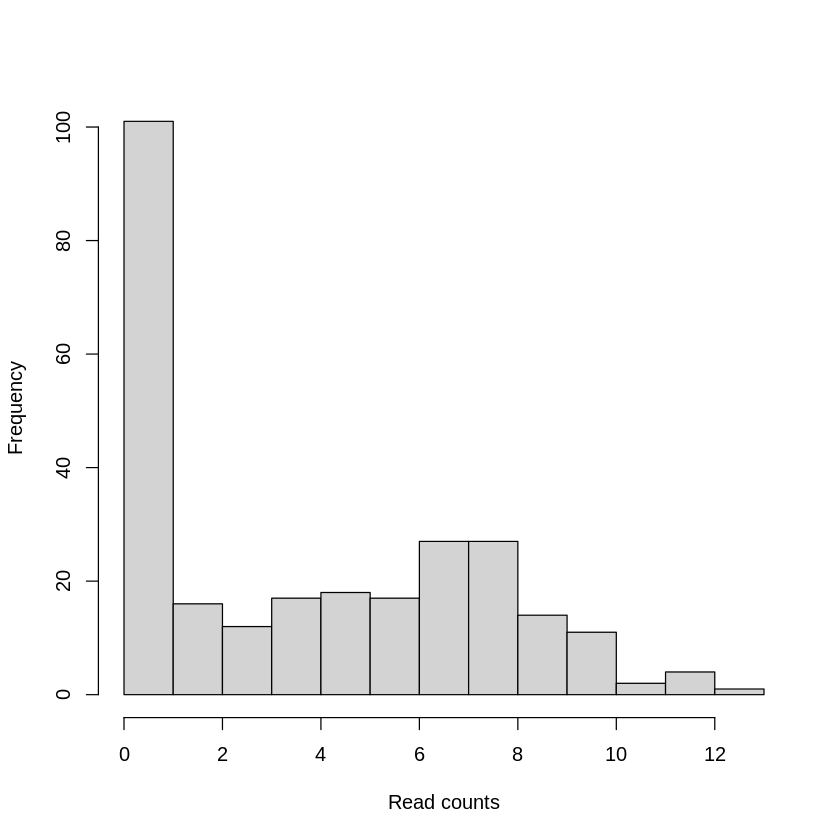

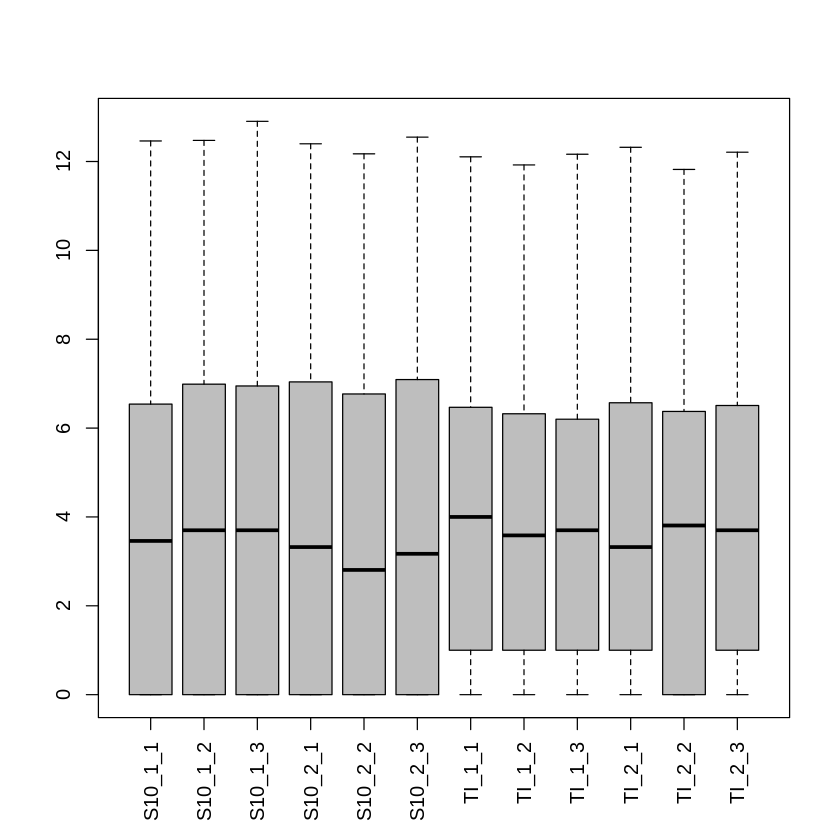

In [7]:
pseudoCounts <- log2(DGEList$counts + 1)
head(pseudoCounts)
hist(pseudoCounts[ ,"S10_1_1"], main = "", xlab = "Read counts")
boxplot(pseudoCounts, col = "gray", las = 3, cex.names = 1)

We can also create a PCA plot of the samples in order to assess the differences between the Genotypes and Conditions, but also between the replicates. In this plot the samples that are similar cluster together, while samples that are different are further apart.
<br>
In this type of plot, we would expect samples from the same group (the three replicates for each sample) to exhibit a similar gene expression profile thus clustering together while being separated from the other samples.

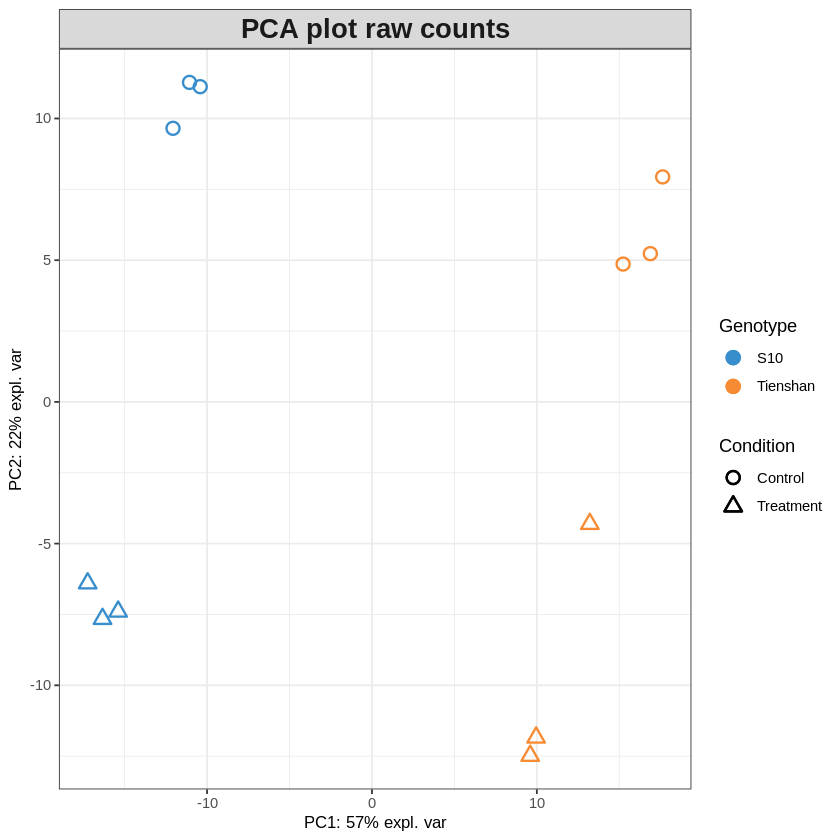

In [8]:
resPCA <- pca(t(pseudoCounts), ncomp = 6)
plotIndiv(resPCA, group = metadata$Genotype, pch=metadata$Condition,
                  legend = T, legend.title = 'Genotype', legend.title.pch = 'Condition',
                  title = 'PCA plot raw counts', style = 'ggplot2', size.xlabel = 10, size.ylabel = 10)

## Filtering the lowly expressed genes
As seen previously, many genes have a low number of read counts in our samples. The genes with very low counts across all libraries provide little evidence for differential expression, thus we should eliminate these genes before the analysis. 
<br>
One of the filtering methods we can use is the "filterByExpr" function provided by the edgeR package. By default, this function keeps only the genes that have at least 10 reads per group, but other cutoffs can also be applied.

In [9]:
keep <- filterByExpr(DGEList, group=metadata$Group) #create the filter
DGEList <- DGEList[keep, , keep.lib.sizes=FALSE] #apply the filter to on the DGEList object
table(keep) #Check the number of genes that passed the filter

keep
FALSE  TRUE 
  104   163 

## Normalization
As we are working with multiple samples we need to normalize the read counts per gene in order to account for compositional and technical differences between the 12 RNA-seq libraries. For this, we will calculate normalization factors using the trimmed mean of M-values (TMM) method. You can read more about different normalization methods in the user manual.  
<br>
Note that running "calcNormFactors" does not change the actual reads per gene counts, it just fills the "norm.factors" column in `DGEList$samples`. 

These factors will be used to scale the read counts for each library.
From the user guide: "A normalization factor below one indicates that a small number of high count genes
are monopolizing the sequencing, causing the counts for other genes to be lower than would
be usual given the library size."

In [10]:
DGEList <- calcNormFactors(DGEList, method="RLE")
DGEList$samples

,group,lib.size,norm.factors,Condition,Genotype
,<fct>,<dbl>,<dbl>,<fct>,<fct>
S10_1_1,S10_Control,43506,1.0897129,Control,S10
S10_1_2,S10_Control,58660,1.0385093,Control,S10
S10_1_3,S10_Control,62512,1.0362962,Control,S10
S10_2_1,S10_Treatment,59741,0.9802860,Treatment,S10
S10_2_2,S10_Treatment,56653,0.8418644,Treatment,S10
S10_2_3,S10_Treatment,63008,0.8949144,Treatment,S10
TI_1_1,Tienshan_Control,43174,1.0618440,Control,Tienshan
TI_1_2,Tienshan_Control,38203,1.0431678,Control,Tienshan
TI_1_3,Tienshan_Control,40178,1.0676351,Control,Tienshan


## Normalized counts - Exploratory Data analysis
For data analysis purposes normalized log2 counts can be extracted from the DGEList object using the function CPM (counts per million).

We will generate the same plots as for the raw counts in order to compare the data before and after normalization. 

Do the plots for normalized counts look different compared with the plots computed before data filtering and normalization? 

,S10_1_1,S10_1_2,S10_1_3,S10_2_1,S10_2_2,S10_2_3,TI_1_1,TI_1_2,TI_1_3,TI_2_1,TI_2_2,TI_2_3
g175,11.568005,11.864813,11.782957,11.863090,12.083127,11.749272,12.323049,12.334198,12.178544,12.112851,12.175386,11.908906
g176,8.564108,7.760868,7.974199,7.290213,8.292080,8.405708,9.349782,8.956131,9.490388,7.125494,8.054467,9.111569
g180,15.836359,16.387906,16.035457,16.109276,16.038322,16.329943,14.435626,15.008665,14.340400,15.704307,14.482504,15.860317
g181,13.287211,13.446752,13.138771,12.869139,13.000828,12.965820,13.775545,14.101988,13.989757,13.664955,13.327806,13.217591
g182,8.716557,8.056048,8.360376,7.439590,7.551908,6.505541,8.245462,7.611500,7.689402,7.125494,7.041192,6.815835
g184,9.350249,8.573811,9.628852,9.955925,11.089735,10.542877,9.653135,9.546090,8.779819,11.073313,10.609695,11.024686


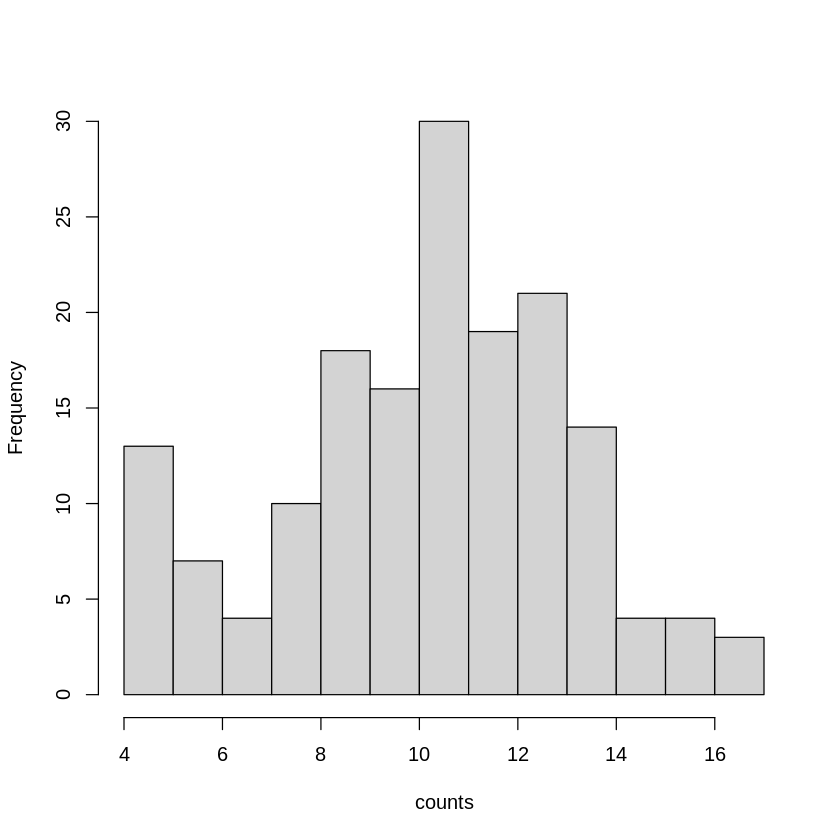

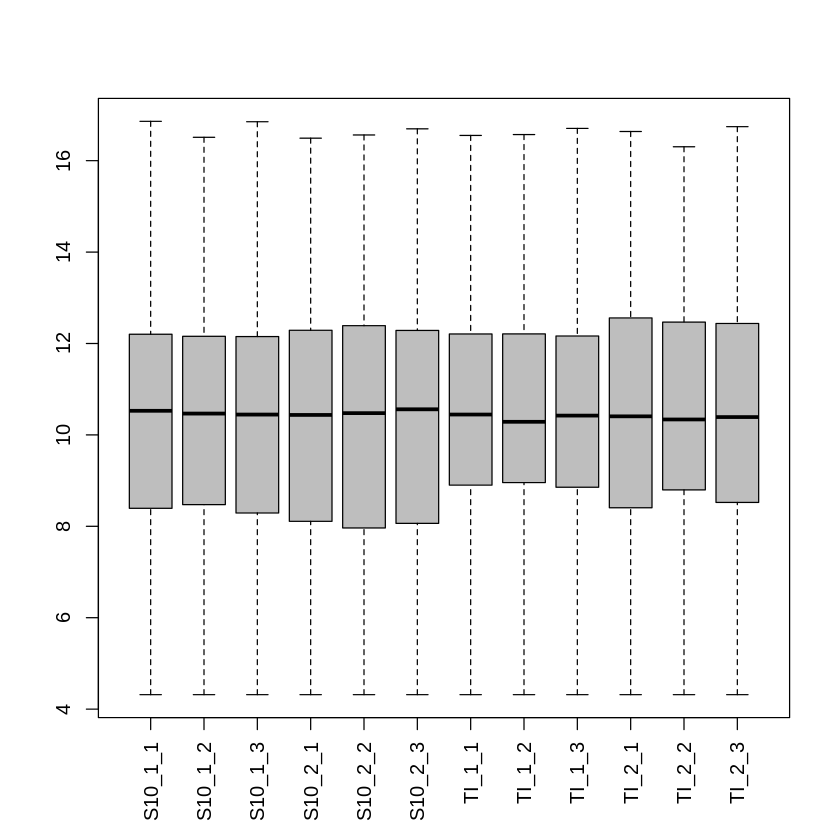

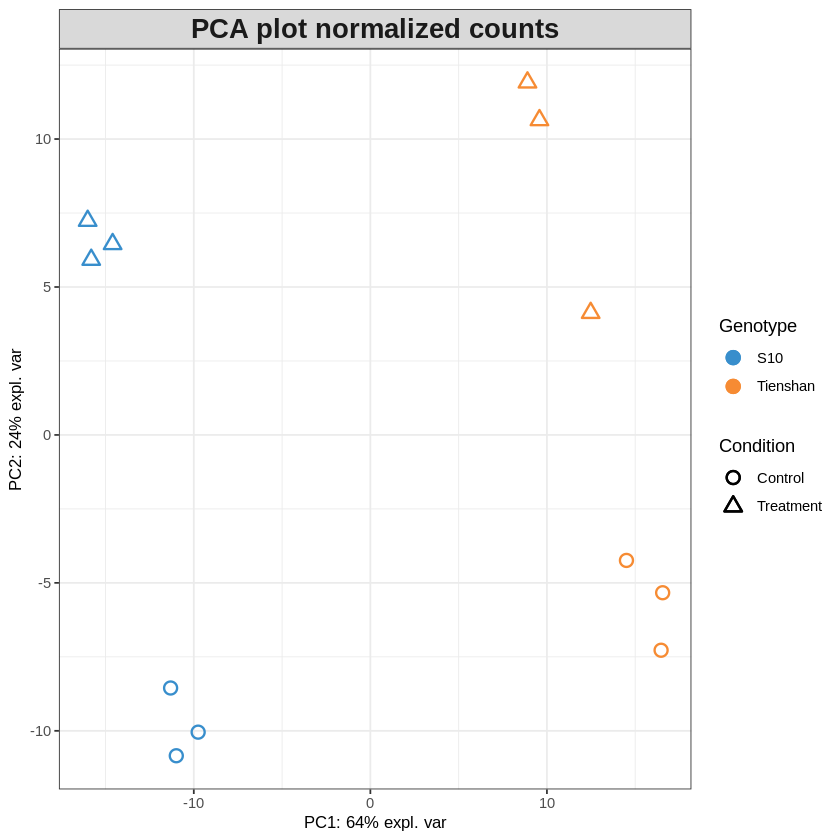

In [11]:
pseudoNormCounts <- cpm(DGEList, log = TRUE, prior.count = 1)
head(pseudoNormCounts)
hist(pseudoNormCounts[ ,"S10_1_1"], main = "", xlab = "counts")
boxplot(pseudoNormCounts, col = "gray", las = 3, cex.names = 1)

resPCA <- pca(t(pseudoNormCounts), ncomp = 6)
plotIndiv(resPCA, group = metadata$Genotype, pch=metadata$Condition,
                  legend = T, legend.title = 'Genotype', legend.title.pch = 'Condition',
                  title = 'PCA plot normalized counts', style = 'ggplot2', size.xlabel = 10, size.ylabel = 10)

# EdgeR - Testing for Differentially expressed genes (DEGs)

We use `edgeR` for Differential Gene Expression using the GLM method (Generalized linear model) with treatment and genotype effects


After we concluded the exploratory data analysis and the filtering and normalization steps we can now start testing for differentially expressed genes between our samples. 


For this, we first need to define a "design matrix" which describes our experimental design. We construct a matrix containing samples as rows and our previously defined groups (S10_Control, S10_Treatment, Tienshan_Control, Tienshan_Treatment) as columns. The samples belonging to each group are assigned a "1" in this matrix.   

In [12]:
design.matrix <- model.matrix(~0+Group)
rownames(design.matrix) <- colnames(DGEList)
colnames(design.matrix) <- levels(metadata$Group)
design.matrix

,S10_Control,S10_Treatment,Tienshan_Control,Tienshan_Treatment
S10_1_1,1,0,0,0
S10_1_2,1,0,0,0
S10_1_3,1,0,0,0
S10_2_1,0,1,0,0
S10_2_2,0,1,0,0
S10_2_3,0,1,0,0
TI_1_1,0,0,1,0
TI_1_2,0,0,1,0
TI_1_3,0,0,1,0
TI_2_1,0,0,0,1


For easier pairwise comparisons between the groups we can create some "contrasts" using the "makeContrasts" function. This will tell the program which samples we will like to consider as our "Control" and which as our "Treatment" groups. The Control groups will be assigned a "-1" and the Treatment groups a "1". When using multiple Control and Treatment samples in the same contrast we need to devide by the number of samples used as for example in the contrast S10_Tienshan, where we use both S10 and Ti samples.

For example, the contrast `S10 = S10_Treatment - S10_Control` will test for differentially expressed genes between the S10 treatment samples vs the S10 Control samples. 

In [13]:
contrasts <- makeContrasts(
                S10 = S10_Treatment-S10_Control,
                Tienshan = Tienshan_Treatment-Tienshan_Control,
                S10_Tienshan= (S10_Treatment+Tienshan_Treatment)/2 - (S10_Control+Tienshan_Control)/2,
                levels=design.matrix)
contrasts

,S10,Tienshan,S10_Tienshan
S10_Control,-1,0,-0.5
S10_Treatment,1,0,0.5
Tienshan_Control,0,-1,-0.5
Tienshan_Treatment,0,1,0.5


*   *Any ideas for other contrasts that migth be interesting to explore?*







The following cell will run two mandatory steps in order to fit a model in edgeR. First, the dispersion needs to be estimated, this is a measure of the degree of inter-library variation for each gene. Afterwards, a QL ( quasi-likelihood) model representing the sample design is fitted using the "glmQLFit" function. You can read more about these steps in the edgeR user guide.

In [14]:
DGEList <- estimateDisp(DGEList, design.matrix)
fit <- glmQLFit(DGEList, design.matrix)

## DEGs for White clover S10 plants Treatment vs Control

Find DEGs for White clover S10 plants in Treatment condition compared with the Control condition
We will test for differentially expressed genes using the quasi-likelihood F-tests method. This is easily done just by running the "glmQFTest" function on the fit model and selecting one of the contrasts we created above (in this case the "S10" contrast).

Next, we will use the topTags function to extract the information about all the genes.

In [15]:
glmqlf_S10 <- glmQLFTest(fit, contrast=contrasts[,"S10"])
DEG_S10 <- topTags(glmqlf_S10, n = nrow(DGEList$counts))
DEG_S10

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g39,3.5861702,14.124630,336.66158,5.227331e-10,8.520550e-08
g232,4.0494125,11.950441,157.50997,3.685988e-08,2.591779e-06
g6,2.3225347,12.999541,150.27854,4.770146e-08,2.591779e-06
g350,2.0530029,13.324566,97.56453,4.890245e-07,1.992775e-05
g99,-1.5387874,11.681004,85.17478,9.976659e-07,3.195090e-05
g142,-1.4235276,13.830692,82.52308,1.176107e-06,3.195090e-05
g240,1.3603712,14.708794,79.98114,1.383201e-06,3.220882e-05
g269,-1.4191681,11.834217,75.66563,1.841279e-06,3.751606e-05
g26,2.1254241,11.366827,68.55898,3.047273e-06,5.518949e-05


We have now created a table with certain parameters calculated for each of the genes analysed.

**logFC** represents the base 2 logarithm of the fold change and it shows us how much the expression of the gene has changed between the two conditions. A logFC of 1 means a doubling in the read per gene count between the control and treatment samples.
The genes with a logFC higher than 0 are upregulated while the genes with a logFC lower than 0 are downregulated between the control and treatment samples. 
<br>
**logCPM** represents the average log2-counts-per-million, the abundance of the gene.

**F** - F-statistic.

**PValue** is the raw p-value.

**FDR** (The false discovery rate) represents the adjusted p-value and is calculated using Benjamini and Hochberg's algorithm. It controls the rate of false positive values under multiple testing. Usually, a threshold of under 5% is set for the FDR.  

The important information for us in this table is stored in the "logFC" and the "FDR" columns. The top DE genes have small FDR values and large fold changes

Many of the genes in the samples are uninteresting for us, as they have a high FDR and/or low logFC values so we cannot consider them as differentially expressed.

We will apply a filtering step in order to keep only the statistically significant genes. We will filter out the genes with an FDR higher than 0.05 and an absolute logFC lower than 1.

In [16]:
DEG_S10_filtered <- DEG_S10$table[DEG_S10$table$FDR < 0.05 & abs(DEG_S10$table$logFC) > 1,] #Filtering
DEG_S10_filtered <- rownames_to_column(DEG_S10_filtered) %>% rename(gene_ID = rowname) #Adding the gene_ID column
head(DEG_S10_filtered)
nrow(DEG_S10_filtered) # finding the number of genes that passed the filter 

,gene_ID,logFC,logCPM,F,PValue,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,g39,3.586170,14.12463,336.66158,5.227331e-10,8.520550e-08
2,g232,4.049413,11.95044,157.50997,3.685988e-08,2.591779e-06
3,g6,2.322535,12.99954,150.27854,4.770146e-08,2.591779e-06
4,g350,2.053003,13.32457,97.56453,4.890245e-07,1.992775e-05
5,g99,-1.538787,11.68100,85.17478,9.976659e-07,3.195090e-05
6,g142,-1.423528,13.83069,82.52308,1.176107e-06,3.195090e-05


[1] 52

We can also visualize the selected genes by plotting a Smear plot or a Volcano plot. The Genes that passed the filter are coloured in red, and the top 10 genes with the lowest FDR value are labelled with their gene ID.

We can see that the majority of the genes analysed are either not statistically significant or have a very small logFC.

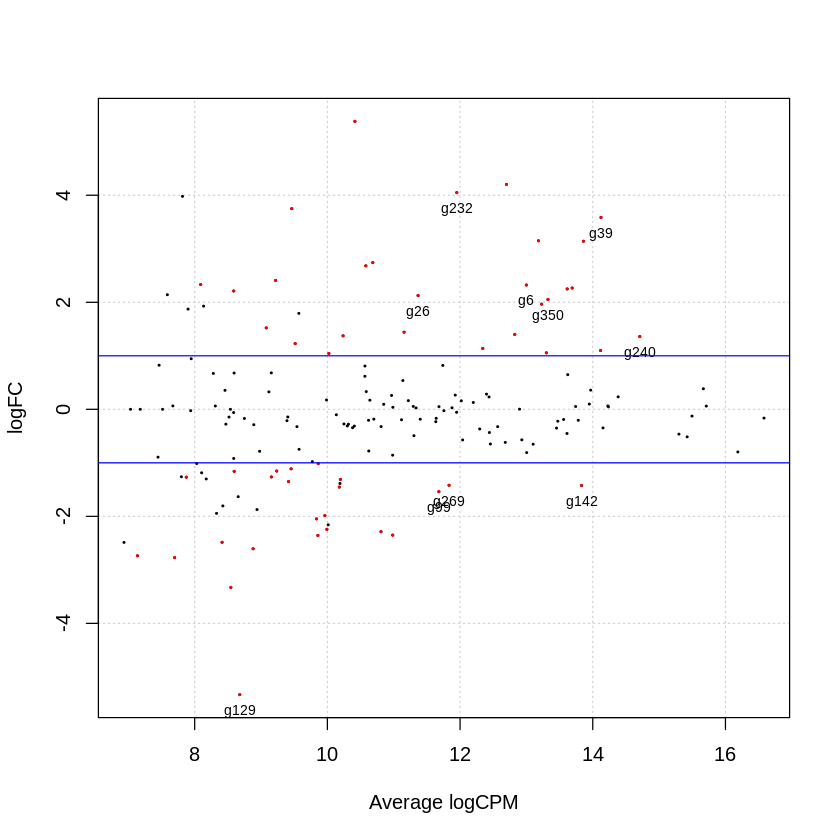

In [17]:
plotSmear(glmqlf_S10,
          de.tags = rownames(DEG_S10$table)[which(DEG_S10$table$FDR < 0.05 & abs(DEG_S10$table$logFC) > 1)])
text(x=DEG_S10_filtered$logCPM[1:10],
     y=DEG_S10_filtered$logFC[1:10],
     labels=DEG_S10_filtered$gene_ID[1:10], cex=0.7, pos=1)
abline(h = c(-1, 1), col = "blue")

We can also create a heatmap with the log2 read counts of the selected differentially expressed genes so that we can visualise the differences in normalized counts between the Control and the Treatment samples.

The genes are ordered by the FDR value. 

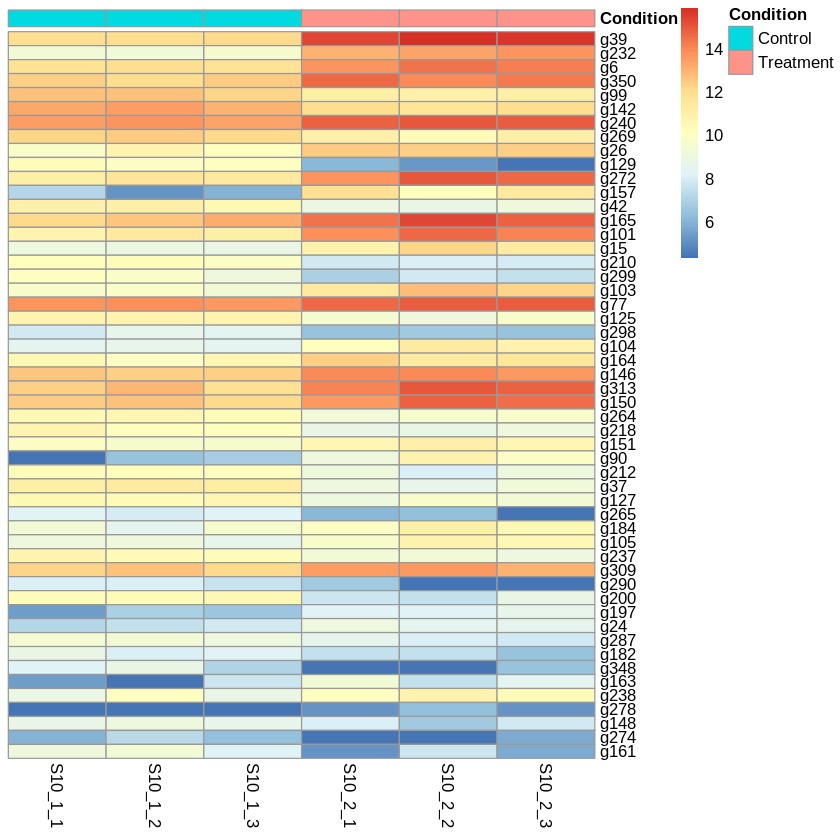

In [18]:
annot_col <- data.frame(row.names = colnames(pseudoNormCounts)[1:6], Condition = c(rep("Control", 3),rep( "Treatment", 3)))                   
pheatmap(as.matrix(pseudoNormCounts[DEG_S10_filtered$gene_ID,c(1:6)]), cluster_rows = F, cluster_col = F, annotation_col = annot_col)

## DEGs for White clover Tienshan Treatment vs Control
We can do this using the same functions as above and changing the contrast.

This time we will directly filter the differentially expressed genes using the same parameters as for the S10 samples.

In [19]:
glmqlf_Ti <- glmQLFTest(fit, contrast=contrasts[,"Tienshan"])
DEG_Ti <- topTags(glmqlf_Ti, n = nrow(DGEList$counts))
DEG_Ti_filtered <- DEG_Ti$table[DEG_Ti$table$FDR < 0.05 & abs(DEG_Ti$table$logFC) > 1,]
DEG_Ti_filtered <- rownames_to_column(DEG_Ti_filtered) %>% rename(gene_ID = rowname)
print(head(DEG_Ti_filtered))
print("Nr of differentially expressed genes:")
print(nrow(DEG_Ti_filtered))

  gene_ID     logFC   logCPM         F       PValue          FDR
1    g234 -3.348667 13.00417 278.01679 1.547626e-09 2.522630e-07
2    g269 -1.885843 11.83422 127.39949 1.172628e-07 9.556922e-06
3     g26  2.423725 11.36683  74.33983 2.016212e-06 8.910761e-05
4    g101  4.303290 13.18162  73.17140 2.186690e-06 8.910761e-05
5    g272  3.391225 13.86065  66.80131 3.475790e-06 9.840357e-05
6     g99 -1.430395 11.68100  66.25814 3.622217e-06 9.840357e-05
[1] "Nr of differentially expressed genes:"
[1] 42


We can now plot a Venn diagram with the DEGs for the two genotypes in order to observe the number of common and specific differentially expressed genes between the two genotypes as response to the cold exposure. You can see that a high percentage of the identified genes are common for the two genotypes, while each genotype has also specific genes.

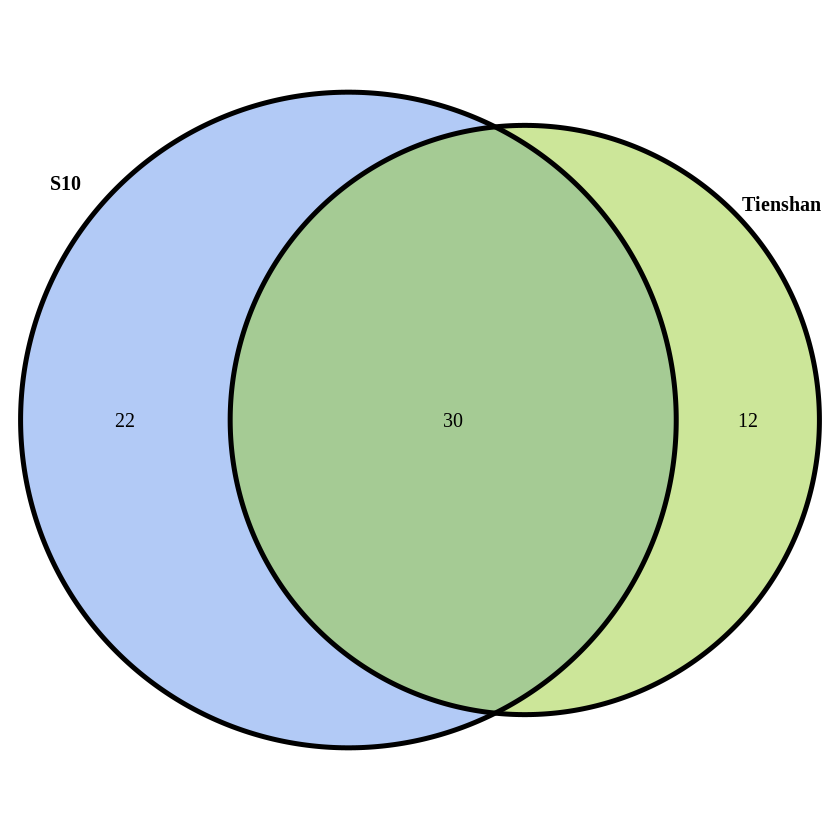

In [20]:
vd <- venn.diagram(
  x = list(DEG_S10_filtered$gene_ID, DEG_Ti_filtered$gene_ID),
  category.names = c("S10" , "Tienshan"),
  lwd = 4,
  fill = c("cornflowerblue", "yellowgreen"),
  filename = NULL,
  cat.cex = 1,
  cat.fontface = "bold",
  output=TRUE
)
grid.draw(vd)

## DEGs for S10+Tienshan Treatment vs Control w/o genotype effects

Until now we tested for DEGs specific for each of the two genotypes under cold treatment. We can also run a test where we ignore the genotype and just test for the differences in the cold response.
<br>
Consider the counts for both genotypes as a single dataset using the previously created contrast "S10_Tienshan". 
<br>
* Do the results look different compared with the previous tests?

In [21]:
glmqlf_S10_Ti <- glmQLFTest(fit, contrast=contrasts[,"S10_Tienshan"])
DEG_S10_Ti <- topTags(glmqlf_S10_Ti, n = nrow(DGEList$counts))
DEG_S10_Ti_filtered <- DEG_S10_Ti$table[DEG_S10_Ti$table$FDR < 0.05 & abs(DEG_S10_Ti$table$logFC) > 1,]
DEG_S10_Ti_filtered <- rownames_to_column(DEG_S10_Ti_filtered)  %>% rename(gene_ID = rowname)
print(head(DEG_S10_Ti_filtered))
print("Nr of differentially expressed genes:")
print(nrow(DEG_S10_Ti_filtered))

  gene_ID     logFC   logCPM        F       PValue          FDR
1     g39  2.057128 14.12463 246.6519 3.039491e-09 4.954370e-07
2    g232  3.261008 11.95044 203.4580 8.934889e-09 5.288546e-07
3    g269 -1.652505 11.83422 200.3564 9.733520e-09 5.288546e-07
4      g6  1.714849 12.99954 166.2297 2.740066e-08 1.116577e-06
5     g99 -1.484591 11.68100 150.3246 4.762148e-08 1.552460e-06
6     g26  2.274575 11.36683 142.8625 6.290957e-08 1.623160e-06
[1] "Nr of differentially expressed genes:"
[1] 52


Plot the results from the 3 tests in a Venn diagram to visualize the number of common and unique genes

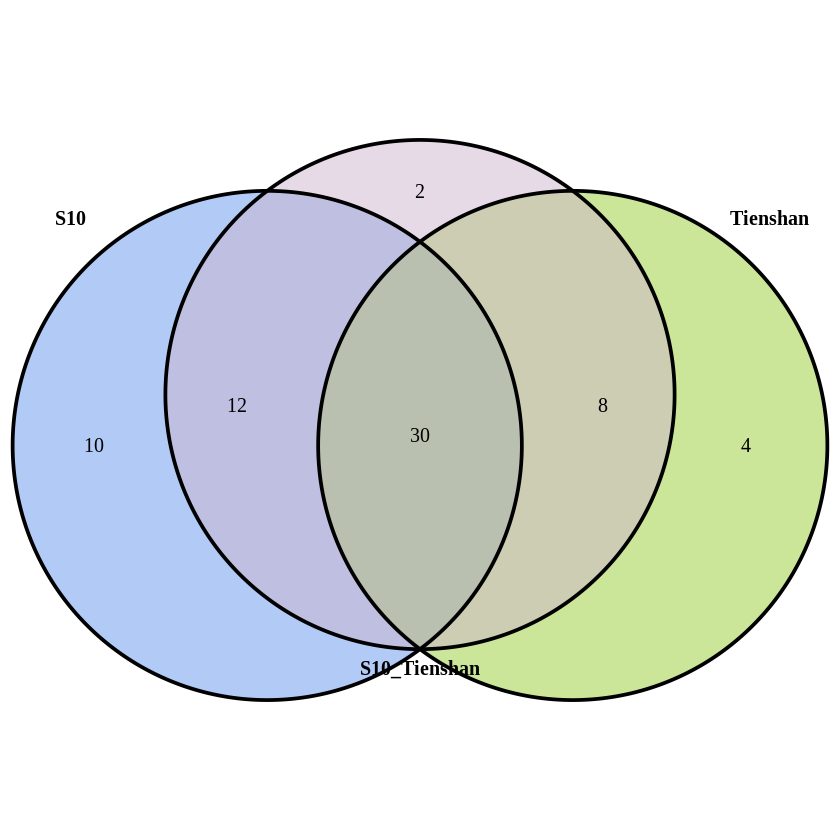

In [22]:
vd <- venn.diagram(
  x = list(DEG_S10_filtered$gene_ID, DEG_Ti_filtered$gene_ID,
           DEG_S10_Ti_filtered$gene_ID),
  category.names = c("S10" , "Tienshan", "S10_Tienshan"),
  lwd = 3,
  fill = c("cornflowerblue", "yellowgreen", "thistle3"),
  filename = NULL,
  cat.cex = 1,
  cat.fontface = "bold",
  output=TRUE
)
grid.draw(vd)

## Explore DGE results

### Select the genes which appear only in the analysis using both genotypes for further examination.

We can use the "anti_join" function from the dplyr package to keep only the unique genes that appear only when using both genotypes.

In [23]:
S10_Ti_unique <- anti_join(DEG_S10_Ti_filtered, DEG_S10_filtered, by="gene_ID") %>%
                       anti_join(DEG_Ti_filtered, by="gene_ID")
S10_Ti_unique

gene_ID,logFC,logCPM,F,PValue,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g247,-1.412652,8.424523,10.877350,0.006535994,0.01500517
g360,1.180849,7.900076,9.804067,0.013809376,0.02813660


### Linking the genes selected as differentially expressed back to the raw read counts

How do the counts look for these genes, does it make sense that they are differentially expressed only when using the two genotypes?

In [24]:
Read_counts <- rownames_to_column(Read_counts) %>% rename(gene_ID = rowname)
S10_Ti_unique_counts <- inner_join(S10_Ti_unique[,c(1,2,6)], Read_counts, by="gene_ID")
S10_Ti_unique_counts

gene_ID,logFC,FDR,S10_1_1,S10_1_2,S10_1_3,S10_2_1,S10_2_2,S10_2_3,TI_1_1,TI_1_2,TI_1_3,TI_2_1,TI_2_2,TI_2_3
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
g247,-1.412652,0.01500517,4,9,3,1,2,1,42,27,32,8,22,22
g360,1.180849,0.02813660,1,0,1,3,2,3,16,10,16,22,19,22


### Adding functional annotation to DEGs
Until now we looked only at gene IDs, but we can also add functional annotations to the DEGs. The functional annotations were generated using protein sequences and the `EggNOG` software.

Identifying the molecular function of the differentially expressed genes can help us do a literature survey in order to check if any of the genes discovered have been previously identified as being involved in the cold response.

In [25]:
Functional_annotations <- read.delim("../Data/Clover_Data/Functional_Annotations.txt")
S10_Ti_unique_FA <- inner_join(S10_Ti_unique[,c(1,2,6)], Functional_annotations, by="gene_ID")
S10_Ti_unique_FA

gene_ID,logFC,FDR,Human.Readable.Description
<chr>,<dbl>,<dbl>,<chr>
g247,-1.412652,0.01500517,Nitrogen regulatory protein P-II homolog
g360,1.180849,0.02813660,Unknown protein


<div class="alert-success"> <font size="+2"> <b> Tasks and Questions </b> </font> </div>


*   Based on the results obtained in the analysis so far, would you change the cut-off for the FDR and logFC to be more strict or more permissive? Look back at the raw counts for different FDR and logFC values and set the thresholds as you find appropriate.

You can also plot histograms with the FDR and logFC values. 





In [ ]:
 hist(DEG_S10$table$FDR , main = "", xlab = "FDR",  breaks= 200, xlim = range(c(0, 0.1)))

In [ ]:
 hist(DEG_S10$table$logFC , main = "", xlab = "logFC",  breaks= 50, xlim = range(c(-6, 6)))

* Separate the upregulated and downregulated genes for each genotype and append functional annotations to them. 
* Identify the genes that are commonly upregulated in S10 and Tienshan samples and the uniquely upregulated genes for each genotype.
* Why do you think some of the proteins appear in duplicates? <br>

To answer these questions, it may be convenient to save summary tables from R and open them in excel. See the code below for examples of how to do this. Files can be downloaded by right-clicking on the file name.

If you are familiar with R functions, you are welcome to use those for counting.


In [ ]:
dir.create("DEG_Output_tables", showWarnings = FALSE)

In [ ]:
#Create the table with the DEGs, Raw counts(just for the Ti samples in this case, change to columns (2:7) for the S10 samples) and Functional annotations
DEG_Ti_counts_FA <- inner_join(DEG_Ti_filtered[,c(1, 2, 6)], Read_counts[, c(1, 8:13)], by="gene_ID") %>%
                 inner_join(Functional_annotations, by="gene_ID")
#Write the table to file
write.table(DEG_Ti_counts_FA, file = "DEG_Output_tables/Ti_Treatment_Control_DGE.txt", quote = FALSE, row.names = FALSE, sep = "\t")
#Display the first 10 rows of the table
head(DEG_Ti_counts_FA, n=10)

Example for filtering and counting the Up/Down genes. You can easily filter using the "filter()" function just by specifying the dataframe and a logical argument.

In [ ]:
DEG_Ti_up <- filter(DEG_Ti_counts_FA, logFC > 0)
print("Nr of upregulated genes:")
print(nrow(DEG_Ti_up))
DEG_Ti_down <- filter(DEG_Ti_counts_FA, logFC < 0)
print("Nr of downregulated genes:")
print(nrow(DEG_Ti_down))

You can use the "inner_join" and the "anti_join" functions from the dplyr package to select the common and unique genes for each genotype:

`example_file_joined <- inner_join(file1, file2, by="gene_ID")`

# Wrapping up  🎉 🎉 🎉

In this notebook, you have worked with RNA-seq results for two white clover genotypes exposed to one night of cold treatment, aiming to identify genes that change their expression in response to the cold treatment. You have learned to perform exploratory data analysis of raw and normalized RNA-seq read counts. You have also performed differential gene expression using `edgeR`. 